## Bankruptcy prediction using neural networks and other ML algorithms
This jupyter notebook is a modified version of the project I did during the writing of my Master's thesis called 'Neural netwoks in financial institutions'. My aim was to create a banrkuptcy prediction model using a neural network and consequently compare it with other benchmark ML algorithms used for classification, such as logistic regression, random forests and gradient boosting machines. 

The collected data [(seen here)](https://pubmed.ncbi.nlm.nih.gov/31463350/) has information about ~20 000 small and medium Slovak companies in the manufacture industry. The data holds information about 21 financial ratios for each company that have been calculated from public data, collected over three years before the evaluation period, giving us the final number of 63 predictors. The 64th column is the binary output variable, which indicates whether the given company filed for bankruptcy in the evaluation period.

As is the common case with real world data, it is messy and needs some care before we can use it for training algorithms, especially neural networks. The main problems are outliers, missing values and different orders of magnitude of the predictors; therefore, the use of preprocessing steps such as winsorization, scaling and imputation was needed to clean the data before training.

## Setup 
First, we need to load the data and some modules we will use throughout the whole project. 

In [1]:
# Modules
import pandas as pd 
import numpy as np 
import csv

In [2]:
# Load data 
manu_test = pd.read_csv(r'data_manu_final.csv', sep = ';', decimal = ',')
manu_test = manu_test.drop(columns = ['X'])
manu = manu_test.reset_index(drop = True)
# Split into output variable and predictors
X = manu.drop(columns = ['bankrupt'])
y = manu['bankrupt']

## Exploratory analysis 
EDA, or *exploratory data analysis*, is the first step of analysing data, as we need to take a thorough look at the quality of data we are dealing with. Our main concerns are NA values = missing data, so let us take a look at what proportion of values are missing in each of the financial ratios. 

In [9]:
manu.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,bankrupt
0,0.03,0.06,0.07,0.06,0.24,0.49,968.52,84.00,429.42,118.00,...,2.36,5.57,57.56,10.59,0.62,9556.27,5.11,11.43,37.78,0
1,10.68,11.08,12.86,3.52,22.25,26.80,438.14,291.31,15.55,71.61,...,3.16,12.92,68.31,14.46,1.07,18127.50,6.56,6.25,29.41,0
2,6.46,17.93,0.70,1.12,1.12,1.12,39.70,-0.03,8.33,0.00,...,3.58,9.42,72.03,32.39,1.36,NaN,7.75,1.87,30.91,0
3,36.70,55.67,15.58,4.98,6.91,6.91,154.49,27.95,14.46,0.05,...,5.04,58.06,80.15,15.67,0.64,22078.00,3.14,23.78,77.75,0
4,0.12,1.32,0.07,0.18,0.75,1.16,223.90,108.83,142.77,78.80,...,52.11,30.91,98.08,0.03,NaN,7989.63,27.19,19.62,98.89,0


In [6]:
# Proportions of missing values
miss = []
for i in range(manu.shape[1]):
    pocet = manu.iloc[:, i].isna().sum()
    pct = 100 * pocet / manu.shape[0]
    miss.append(pct)
    print('.. %d, Missing Values: %d (%.1f%%)' % (i, pocet, pct))
miss = miss[0:63]

.. 0, Missing Values: 106 (0.5%)
.. 1, Missing Values: 106 (0.5%)
.. 2, Missing Values: 838 (4.3%)
.. 3, Missing Values: 558 (2.9%)
.. 4, Missing Values: 530 (2.7%)
.. 5, Missing Values: 543 (2.8%)
.. 6, Missing Values: 780 (4.0%)
.. 7, Missing Values: 1427 (7.3%)
.. 8, Missing Values: 887 (4.6%)
.. 9, Missing Values: 4104 (21.1%)
.. 10, Missing Values: 425 (2.2%)
.. 11, Missing Values: 422 (2.2%)
.. 12, Missing Values: 106 (0.5%)
.. 13, Missing Values: 106 (0.5%)
.. 14, Missing Values: 133 (0.7%)
.. 15, Missing Values: 521 (2.7%)
.. 16, Missing Values: 3491 (17.9%)
.. 17, Missing Values: 9146 (46.9%)
.. 18, Missing Values: 262 (1.3%)
.. 19, Missing Values: 764 (3.9%)
.. 20, Missing Values: 389 (2.0%)
.. 21, Missing Values: 123 (0.6%)
.. 22, Missing Values: 127 (0.7%)
.. 23, Missing Values: 1277 (6.6%)
.. 24, Missing Values: 326 (1.7%)
.. 25, Missing Values: 295 (1.5%)
.. 26, Missing Values: 301 (1.5%)
.. 27, Missing Values: 482 (2.5%)
.. 28, Missing Values: 1042 (5.3%)
.. 29, Missing 

<AxesSubplot:>

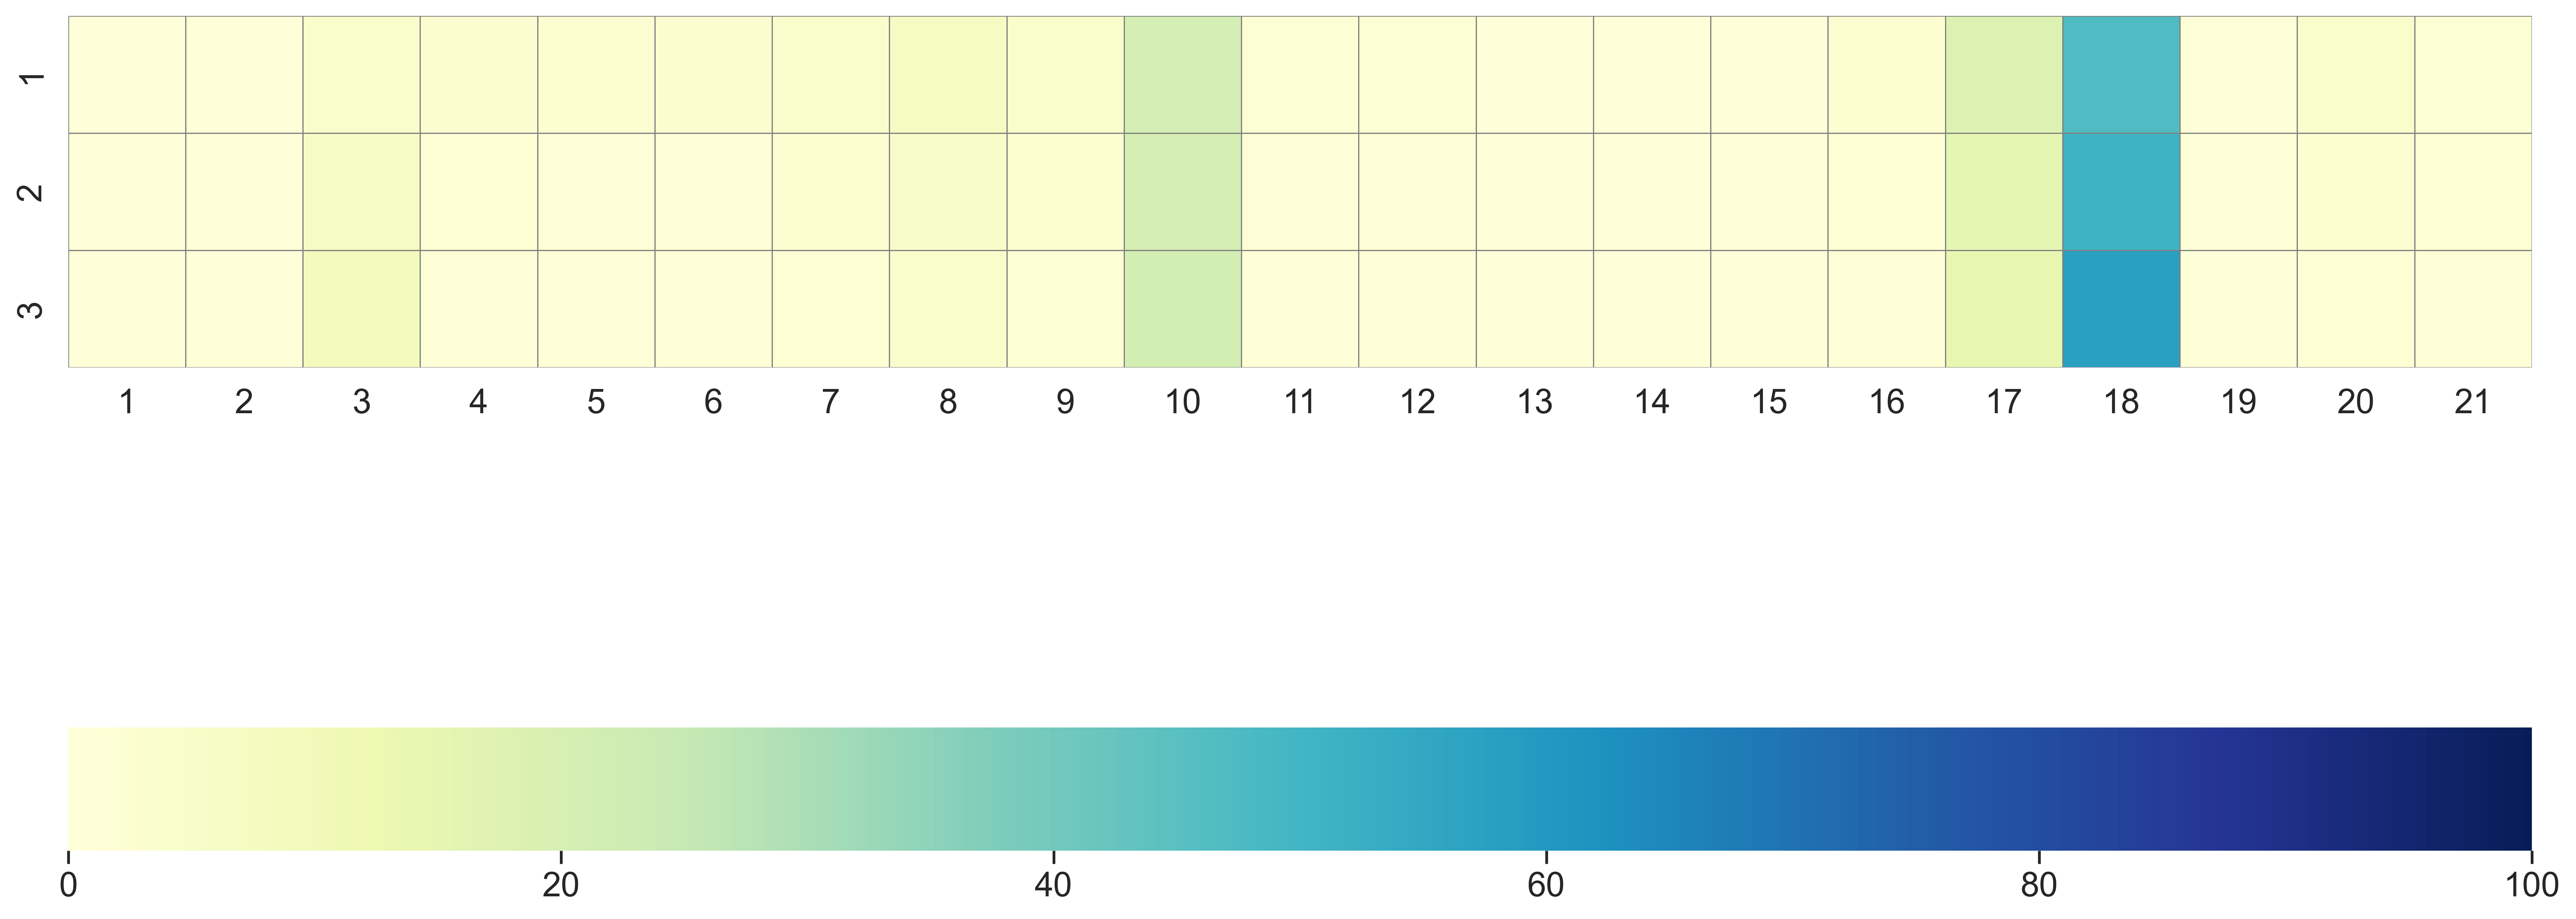

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
pyplot.figure(figsize = (20, 20), dpi = 400)
sns.set(font_scale = 1.4)
miss = np.array(miss)
miss.shape = [3, 21]
df = pd.DataFrame(miss, columns = np.arange(21) + 1, index = np.arange(3) + 1)
sns.heatmap(df, vmin = 0, vmax = 100, cmap = "YlGnBu", square = True,  
            cbar_kws={"orientation": "horizontal"}, linewidths = 0.2, linecolor = 'gray')

As we can see, the most of the columns were missing up to 5% of values, some of them reached up to 20% and three of the columns had a much higher number of NA values. Let us identify the columns that had at least 30% of values missing: 

In [8]:
for i in np.arange(X.shape[1]):
    if X.iloc[:,i].isna().sum() / X.shape[0] >= 0.3:
        print('{} missing data:  {:.1f} %.'.format(X.columns[i], X.iloc[:,i].isna().sum() / X.shape[0] * 100))

V18 missing data:  46.9 %.
V39 missing data:  51.2 %.
V60 missing data:  57.5 %.


These columns correspond to the same financial ratio, collected during the three consecutive years. As the proportions of missing data are too high, I decided to completely omit these predictors in my analysis and algorithm training. I created some transformers that will help us with selecting our wanted columns and winsorization in a proper machine learning pipeline, so I will load them now.

In [3]:
# Winsorization function
def winsor_dat(df, alpha):
    q_low = df.quantile(alpha)
    q_hi = df.quantile(1 - alpha)
    out_low = (df < q_low)
    out_hi = (df > q_hi)
    df = df.mask(out_low, q_low, axis = 1)
    df = df.mask(out_hi, q_hi, axis = 1)
    return df

# Winsorization transformer
def winsor_mask(df, qlo, qhi):
    out_low = (df < qlo)
    out_hi = (df > qhi)
    df = df.mask(out_low, qlo, axis = 1)
    df = df.mask(out_hi, qhi, axis = 1)
    return df
    
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
class WinsorTrans(BaseEstimator, TransformerMixin):
    def __init__(self, alpha = 0.05):
        # Initialization
        self.alpha = alpha
        print('\n > init() called.\n')
    
    def fit(self, X, y = None):
        # Fit lower and upper quantiles, as transformer attributes
        self.qlow = X.quantile(self.alpha)
        self.qhi = X.quantile(1 - self.alpha)
        return self 
    
    def transform(self, X, y = None):
        X_cop = X.copy()
        X_cop = winsor_mask(X_cop, self.qlow, self.qhi)
        return X_cop
    
# Column selection transformer
class SelectCols(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff = 0.3):
        # Initialization
        print('\n > init() called.\n')
        self.cutoff = cutoff
        
    def fit(self, X, y = None):
        # Fit = get indices of columns to be deleted
        drops = []
        for i in range(X.shape[1]):
            rate = X.iloc[:, i].isna().sum() / manu.shape[0]
            if rate >= self.cutoff: drops.append(i)
        self.drop = X.columns[drops]
        self.numcols = len(drops)
        return self 

    def transform(self, X, y = None):
        X_cop = X.copy()
        X_cop = X_cop.drop(self.drop, axis = 1)
        return X_cop

Next up, let's have a look at some boxplots: 

<AxesSubplot:>

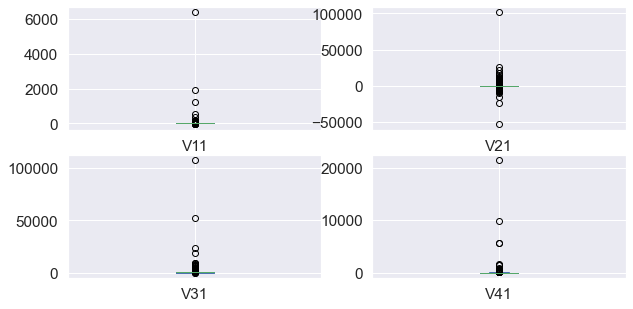

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
axe = ax.ravel()
manu.iloc[:,10].plot.box(ax=axe[0])
manu.iloc[:,20].plot.box(ax=axe[1])
manu.iloc[:,30].plot.box(ax=axe[2])
manu.iloc[:,40].plot.box(ax=axe[3])

The boxplots indicate a large number of outliers that we will need to deal with during the preprocessing phase. Another useful information is the correlation among the financial ratios. The correlation among predictiors in one given year looks like this:


 > init() called.



<AxesSubplot:>

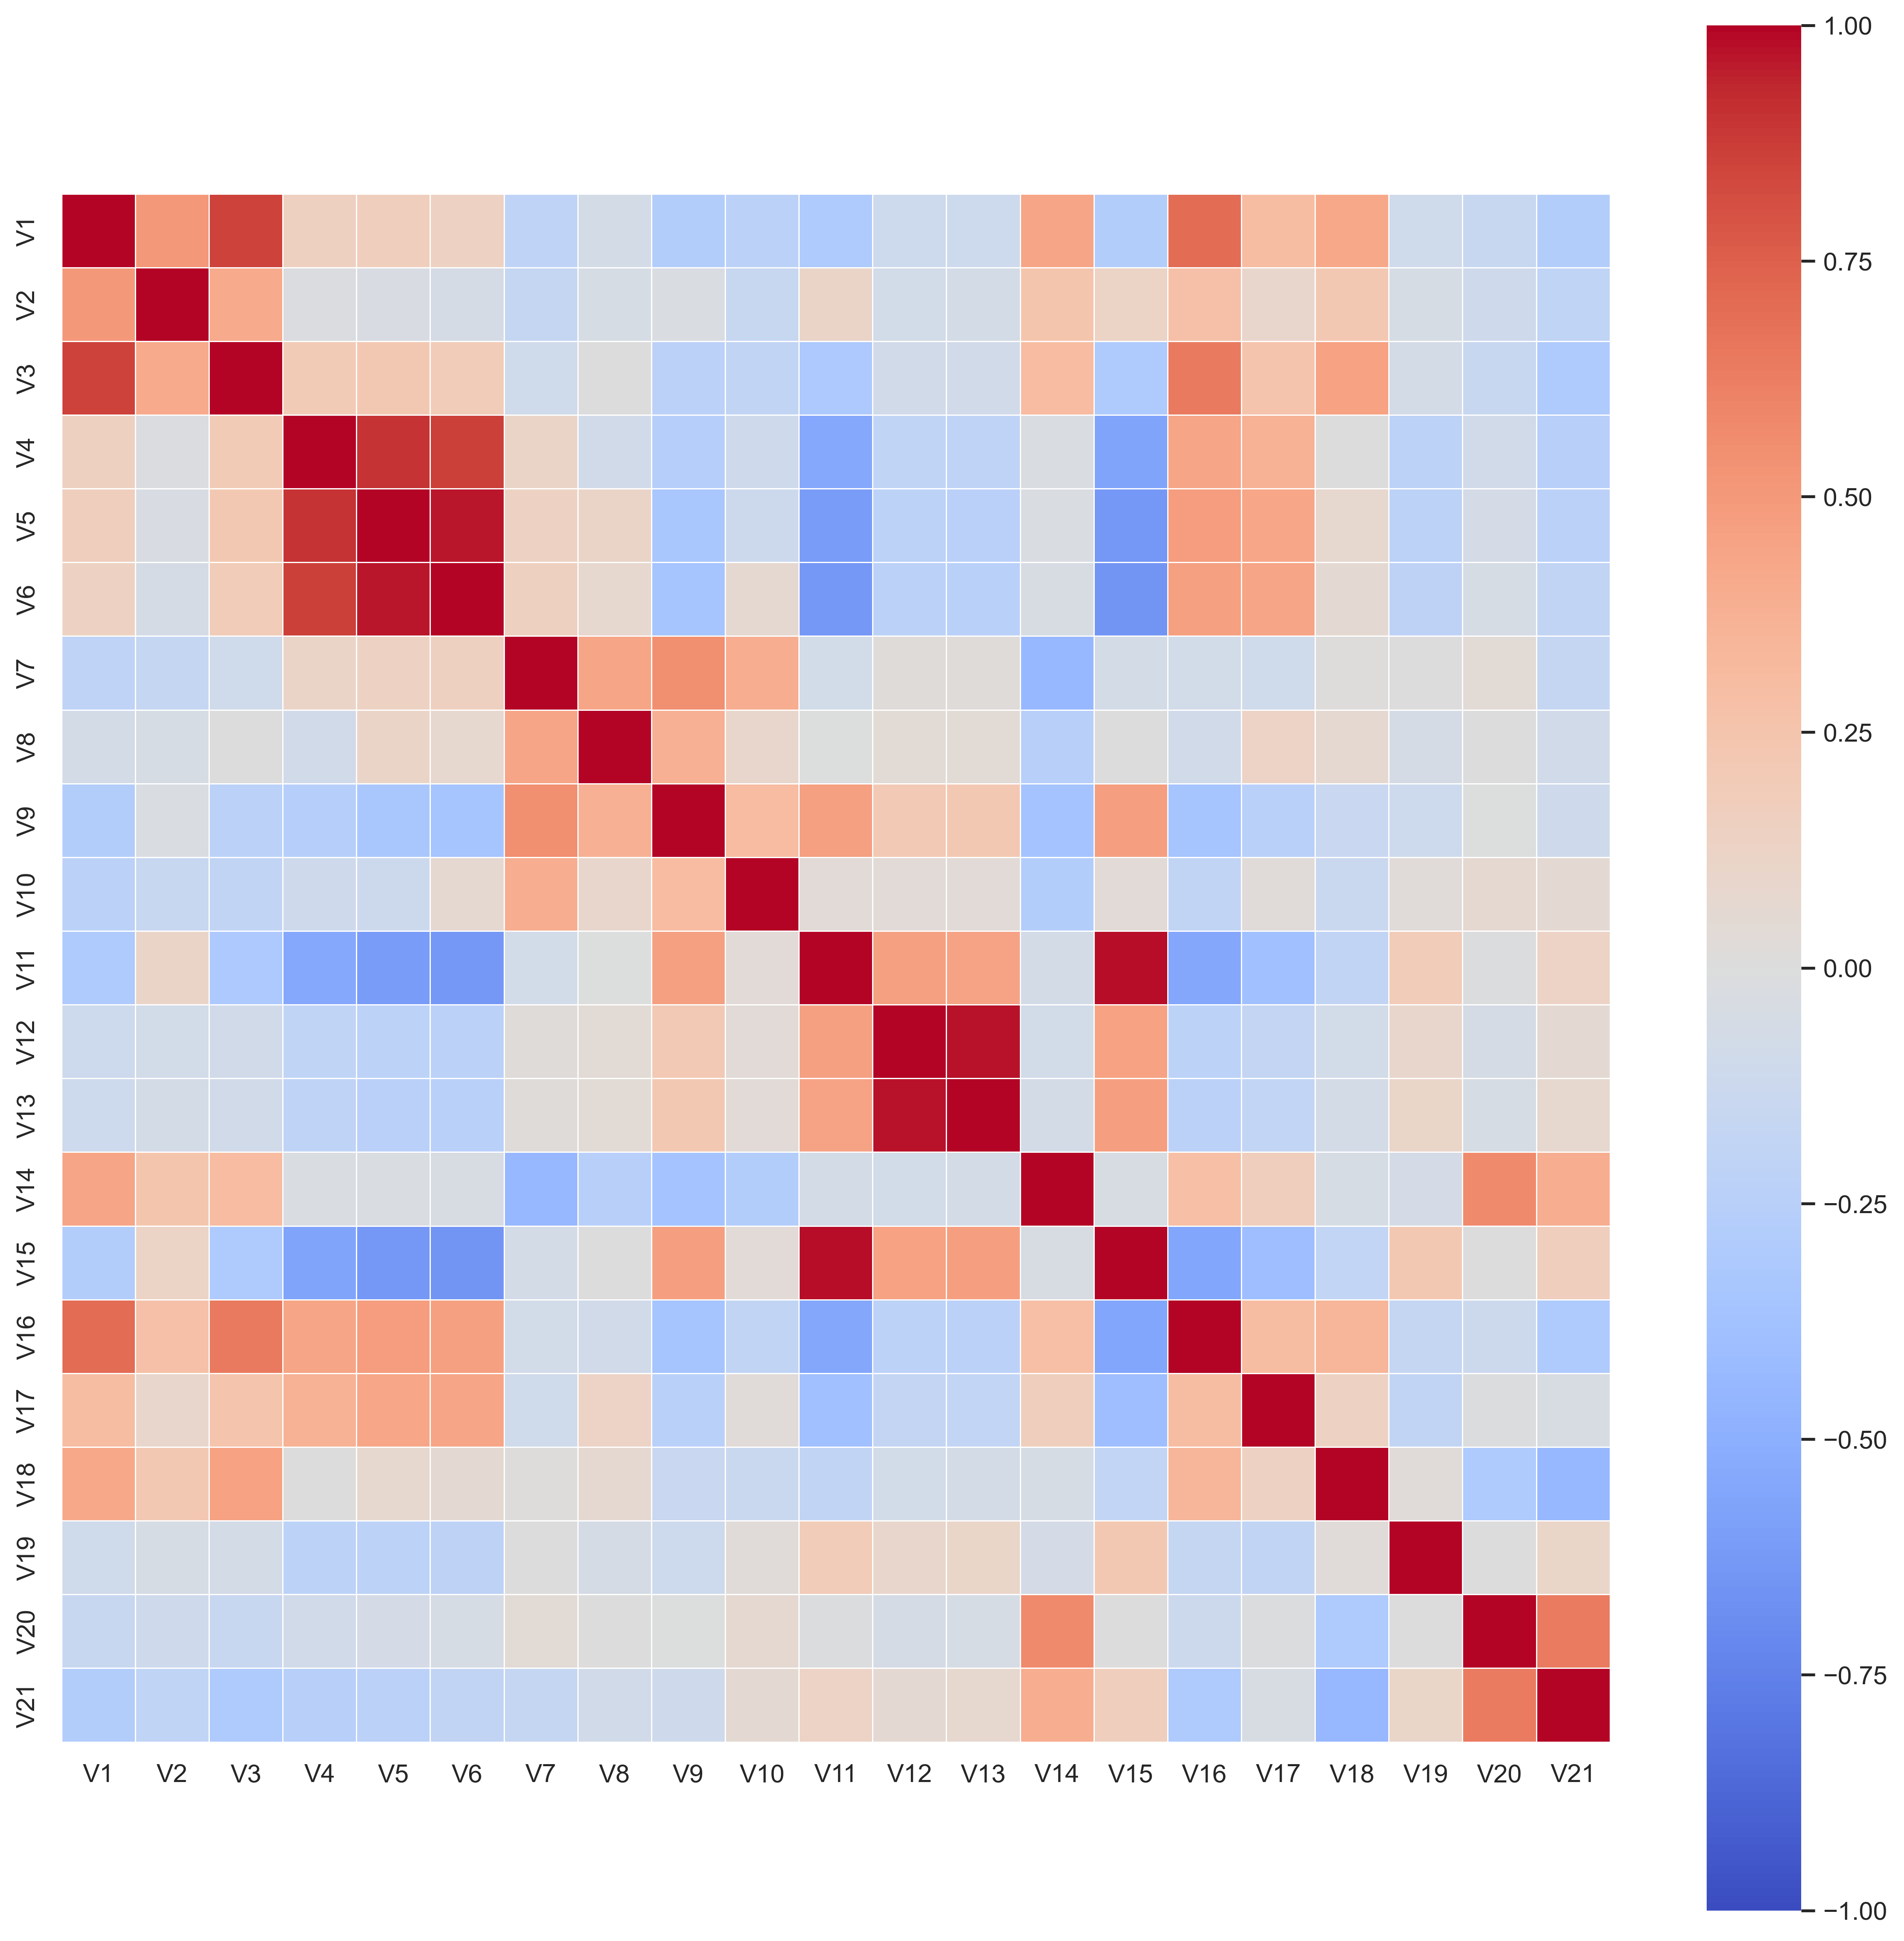

In [35]:
# Correlation matrix
wins = WinsorTrans(alpha = 0.05)
X_winsor = wins.fit_transform(X)
pyplot.figure(figsize = (15, 15), dpi = 400)
sns.set(font_scale = 1)
cor1 = X_winsor.iloc[:, np.arange(21)].corr()
sns.heatmap(cor1, vmin = -1, vmax = 1, square = True,  linewidths = 0.2, linecolor = 'white', cmap = 'coolwarm')

As expected, some of the financial ratios are highly correlated, either positively or negaitvely. Although this is an interesting information, we will fortunately not need to deal with the correlation, as neural networks can create their own (possibly uncorrelated) transformations of the data and other ML algorithms, such as those based on decision trees, are also robust to highly correlated data. 

Next up, we can execute the main split into training and testing data. I opted to do a 80%/20% train/test split. Another problem is the large discrepancy between the negative class (financially healthy companies) and the positive class (the companies that filed for bankruptcy): 

In [50]:
a = manu.iloc[:,63].value_counts()
print('Positive class: %d observations, (%.2f%% of data)' % (a[0], 100 *  a[0] / (a.sum())))
print('Negative class: %d observations, (%.2f%% of data)' % (a[1], 100 *  a[1] / (a.sum())))

Positive class: 19386 observations, (99.49% of data)
Negative class: 100 observations, (0.51% of data)


Since this is a highly imbalanced dataset, we need to stratify the train/test split by the output variable. We will also need to deal with the imbalance during training, by either undersampling the negative class or oversampling the positive class (dupliacation or SMOTE). 

In [4]:
# Select columns & Train test split 
from sklearn.model_selection import train_test_split as tts
col_selector = SelectCols(cutoff = 0.3)
X = col_selector.fit_transform(X)
X_tr, X_ts, y_tr, y_ts = tts(X, y, 
                             test_size = 0.2, 
                             stratify = y, 
                             random_state = 10)
[y_tr.shape, y_ts.shape] 


 > init() called.



[(15588,), (3898,)]

After the split, I decided to divide the hyperparameter optimalization for my neural network into 2 steps: The preprocessing hyperparameters, and the neural network hyperparameters. Ideally, we would do this in one go, but since I will be using grid search cross-validation to find the optimal values of these hyperparameters, such process would take too much time. I therefore assumed that the optimal data cleaning process is independent from the neural network design process. 

In the next cell, I designed the metric by which I will evaluate the quality of my classifiers. I opted for the partial AUC criterion; for brevity, I will not describe the topic of evaluating binary classifiers. 

In [5]:
# Preprocessing hyperparameter tuning
# List for pAUC metric
first = list(range(31))
xseq = [x / 100 for x in first] # max_fpr = (0, 0.3)

For the first step (optimalization of preprocessing hyperparameters), I designed a simple neural network with one hidden layer with 20 neurons. I chose the relu activation function for hidden neurons and otherwise the default setting for a binary classifier neural net. The net is also regularized by the dropout method. 

I want to add the neural net at the end of my machine learning pipeline, therefore I created this *create_net()* function which creates a Keras model, which is then wrapped in a KerasClassifier wrapper. 

In [29]:
# Neural network creator function 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import AUC
def create_net():
    net = Sequential()
    net.add(Dropout(0.3, input_shape = (60, )))
    net.add(Dense(20, activation = 'relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1, activation = 'sigmoid'))
    net.compile(loss = 'binary_crossentropy', 
                optimizer = 'adam', 
                metrics = AUC(thresholds = xseq))
    return net
keras_est = KerasClassifier(build_fn = create_net, 
                            verbose = 1, epochs = 90, batch_size = 128)

In the next step I created the grid of possible hyperparameters setting for preprocessing. The individual steps are then ordered in the *imbpipeline*, which is a Pipeline imported from the *imbalanced-learn* module, which allows me to add undersampling and oversampling to the pipe. This is essential for working with heavily imbalanced datasets, as I am allowing the pipeline to find the best combination of oversampling the positive class (via SMOTE or random oversampling) and undersampling the negative class (via random undersampling, although other techniques can be used).

The imputation will be done by the k-nearest neighbors algorithm, as imputation by the mean showed poor results in previous runs. As described earlier, winsorization will be used to deal with the outliers. Scaling of the data will be done by min-max scaling.

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
preproc_grid = [{
    'outs__alpha' : [0.02, 0.05, 0.1],
    'scaler' : [MinMaxScaler()],
    'imputer' : [KNNImputer()],
    'imputer__n_neighbors' : [3, 5, 7],
    'us' : [RandomUnderSampler()],
    'os' : [RandomOverSampler(), SMOTE()],
    'us__sampling_strategy' :  [0.01, 0.02, 0.05],
    'os__sampling_strategy' : [0.75, 1],
}]

In [31]:
# Preprocessing pipeline
pp = imbpipeline(steps = [['outs', WinsorTrans()], 
                          ['scaler', MinMaxScaler()],
                          ['imputer', KNNImputer()], 
                          ['us', RandomUnderSampler()],
                          ['os', SMOTE()], 
                          ['net', keras_est]])


 > init() called.



After our pipline with its grid has been defined, we can continue to use the *GridSearchCV* function that will repeatedly train the predefined neural net with various hyperparameter settings and test its quality of predictions via cross-validation. This took a very long time (over 15-20 hours if I remember correctly), so it is important to save the .csv file that contains the results of our grid search cross-validaiton, as well as the final model trained on the whole training set.

In [32]:
# Grid search CV for preprocessing hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
part_auc = make_scorer(roc_auc_score, max_fpr = 0.3) # define new scoring metric 
grid_pre = GridSearchCV(estimator = pp, verbose = 4, scoring = part_auc, param_grid = preproc_grid, cv = 4,
                       return_train_score = True)
grid_pre.fit(X_tr, y_tr)


 > init() called.

Fitting 4 folds for each of 108 candidates, totalling 432 fits

 > init() called.



KeyboardInterrupt: 

The reason why we added all the preprocessing steps into a pipeline rather than conducted the tranformation before training, is to avoid data leakage. Data leakage is a rather complex problem to mathematically describe and therefore I will not get into details. Basically, we need to execute the same transformation on the training sets as on the validation sets, otherwise we would get (optimistically) skewed results of our final classifier.

In [17]:
pd.DataFrame(grid_pre.cv_results_).to_csv('preprocess_end.csv')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [18]:
# Save model 
preprocess_mod = grid_pre.best_estimator_.steps[5][1].model.to_json()
open('preprocess_net_konec', 'w').write(preprocess_mod)
 And its weights 
grid_pre.best_estimator_.steps[5][1].model.save_weights('preprocess_net_konec_weights.h5', overwrite = True)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

We can now move up to the second stage; setting the hyperparameters of the actual neural network. We have saved the best results for our preprocessing steps and we will 'hardcode' them into our next pipeline. I defined a new function to create a general neural net with various number of hidden layers, hidden neurons, various choice of activation funciton, regularization etc.:

In [33]:
# Neural network creator function with dropout/L1/L2 regularizations 
from keras import regularizers 
def create_net_reg(layer_sizes = [60], optimizer = 'adam',
                   activ_hidden = 'relu', lamb = 0.01,
                   typ = 'drop', dropout_input = 0.3, 
                   dropout_dense = 0.5):
    net = Sequential()
    if typ == 'l2': 
        reg = regularizers.l2(lamb)
        net.add(Dense(layer_sizes[0], input_dim = 60, 
                      activation = activ_hidden, 
                      kernel_regularizer = reg,
                      bias_regularizer = reg))
        for layer_size in layer_sizes[1:]:
            net.add(Dense(layer_size, activation = activ_hidden, 
                          kernel_regularizer = reg,
                          bias_regularizer = reg))
    if typ == 'l1': 
        reg = regularizers.l1(lamb)
        net.add(Dense(layer_sizes[0], input_dim = 60, 
                      activation = activ_hidden,
                      kernel_regularizer = reg,
                      bias_regularizer = reg))
        for layer_size in layer_sizes[1:]:
            net.add(Dense(layer_size, activation = activ_hidden,
                          kernel_regularizer = reg,
                          bias_regularizer = reg))
    if typ == 'drop':
        net.add(Dropout(dropout_input, input_shape = (60, )))
        for layer_size in layer_sizes:
            net.add(Dense(layer_size, activation = activ_hidden))
            net.add(Dropout(dropout_dense))
    net.add(Dense(1, activation = 'sigmoid'))
    net.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = AUC(thresholds = xseq))
    return net
keras_est_reg = KerasClassifier(build_fn = create_net_reg, verbose = 1, epochs = 60, batch_size = 128)

The process is very similar to the previous case, except we will define the exact preprocessing steps and define a new grid of possible hyperparameter combinations for the actual neural network. The *RandomizedSearchCV* function is used to find the best combinations of hyperparameters by evaluating the models on the validation datasets via cross-validation. The only differnce from *GridSearchCV* is our ability to choose the number of hyperparameter combinations we will choose. I settled for 200 combinations, which already comes to training 800 neural nets combined with the rather lengthy preprocessing steps to avoid data leakage. 

In [8]:
# Define pipelines
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
net = imbpipeline(steps = [['outs', WinsorTrans(alpha = 0.05)], 
                           ['scaler', MinMaxScaler()],
                           ['imputer', KNNImputer(n_neighbors = 5)], 
                           ['us', RandomUnderSampler(sampling_strategy = 0.02)], 
                           ['os', SMOTE(sampling_strategy = 0.75)], 
                           ['net', keras_est_reg]])
fin_grid = [
    {
    'net__layer_sizes' : [[20], [40], [60], [30, 10], 
                          [50, 30], [20, 10, 5]],
    'net__optimizer' : ['adam', 'rmsprop'], 
    'net__activ_hidden' : ['relu', 'tanh'],
    'net__lamb' : [0.01, 0.001, 0.0001], 
    'net__typ' : ['l2']
},
    {
    'net__layer_sizes' : [[20], [40], [60], [30, 10], 
                          [50, 30], [20, 10, 5]],
    'net__optimizer' : ['adam', 'rmsprop'], 
    'net__activ_hidden' : ['relu', 'tanh'],
    'net__dropout_input' : [0.1, 0.3, 0.5],
    'net__dropout_dense' : [0.3, 0.5, 0.7],
    'net__typ' : ['drop']  
}]


 > init() called.



NameError: name 'keras_est_reg' is not defined

This learning process also takes a really long time (over 24 hours), so it is important that I saved the results after executing these blocks of code.

In [36]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
part_auc = make_scorer(roc_auc_score, max_fpr = 0.3)
grid_net = RandomizedSearchCV(estimator = net, verbose = 4, scoring = part_auc, param_distributions = fin_grid, cv = 4,
                              n_iter = 200, return_train_score = True)
grid_net.fit(X_tr, y_tr)


 > init() called.

Fitting 4 folds for each of 200 candidates, totalling 800 fits

 > init() called.



KeyboardInterrupt: 

In [89]:
# Save the results
pd.DataFrame(grid_final.cv_results_).to_csv('net_konec.csv')

In [90]:
# Save the model 
final_mod = grid_final.best_estimator_.steps[5][1].model.to_json()
open('konec_net3.json', 'w').write(final_mod)
# And its weights 
grid_final.best_estimator_.steps[5][1].model.save_weights('konec_net_weights3.h5', overwrite = True)

Since I already trained and saved the best neural network model as well as the other ML algorithms used (logistic regression, random forest and gradient boosting machine), we can simply load the models and compare them. The process of optimalization for the other algortihms was very similar that of the neural network and the code blocks are shown lower in the project.

Let us move on and finally compare the models; I will load the already trained models and their predictions. Since the neural network is loaded in a different format, I need to do the preprocessing step manually on the test dataset.  

In [6]:
# Final evalutaion of benchmark models/neural net, loading finished models
import joblib 
rf = joblib.load('rf_upraveny.pkl')
logreg = joblib.load('logreg_konec.pkl')
gbm = joblib.load('gbm_konec.pkl')
rf_probs = rf.predict_proba(X_ts)
logreg_probs = logreg.predict_proba(X_ts)
gbm_probs = gbm.predict_proba(X_ts)

In [9]:
## Final evaluaiton, ANN
from sklearn.pipeline import Pipeline
from keras.models import model_from_json
ann = model_from_json(open('konec_net3.json').read())
ann.load_weights('konec_net_weights3.h5')

# Create pipeline again 
preprocess = Pipeline(steps = [['outs', WinsorTrans(alpha = 0.05)], 
                               ['scaler', MinMaxScaler()],
                               ['imputer', KNNImputer(n_neighbors = 5)]])
preprocess.fit(X_tr)
X_ts_pp = preprocess.transform(X_ts)


 > init() called.



In [10]:
# ANN predictions
ann_probs = ann.predict(X_ts_pp)

The best and robust way to compare several binary classifiers is arguably the Receiver operating characteristic (ROC curve). This [curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) plots the true positive rate (TPR) agianst the false positive rate (FPR) for various cut-off values of a binary classifier. Remember, the output of our algorithm is not the predicted category; the output is merely a *probability* our model thinks that the given observation belongs to the positive class. It is then up to the analyst to choose the cut-off value to suit the needs of a problem we are trying to solve by training these machine learning algorithms. Depending on the nature of our problem, a type I error (false positive) might have way worse implications in real life than a type II error (false negative), or vice versa. 

The ROC curve always starts in the origin and ends in the (1,1) point. The better the classifier, the closer its ROC curve is to the upper left corner (or (0, 1) point), which implies that the classifier is able to predict all observations in the test set correcly, for some cut-off value. In real life, it is very rare to encounter data for which a perfect classifer can be created. The *Area Under Curve* (AUC) is therefore used to compare several models by a single metric. This value between 0 and 1 literally means the area under the ROC curve. A model that randomly guesses the category of observations will have AUC around 0.5 and models close to 1 are those that are very good at predicting the correct category. Hence, the higher the AUC, the more precise our model is. 

This is very important especially in our case, as we are dealing with a highly imbalanced dataset. Some simpler metrics, such as accuracy, are going to be misleading, as a pseudomodel which predicts only negative class for all observations will achieve about 99.5% accuracy, which may seem great, while in reality the model is completely useless.  

In this project, I used the *partial* AUC metric, which uses a standardized area under a part of the ROC curve. For example, I looked at the curve at the parts where false positive rate was less than 30%, as I am less interested in how the models performed with such a high FPR. 

Text(0, 0.5, 'TPR')

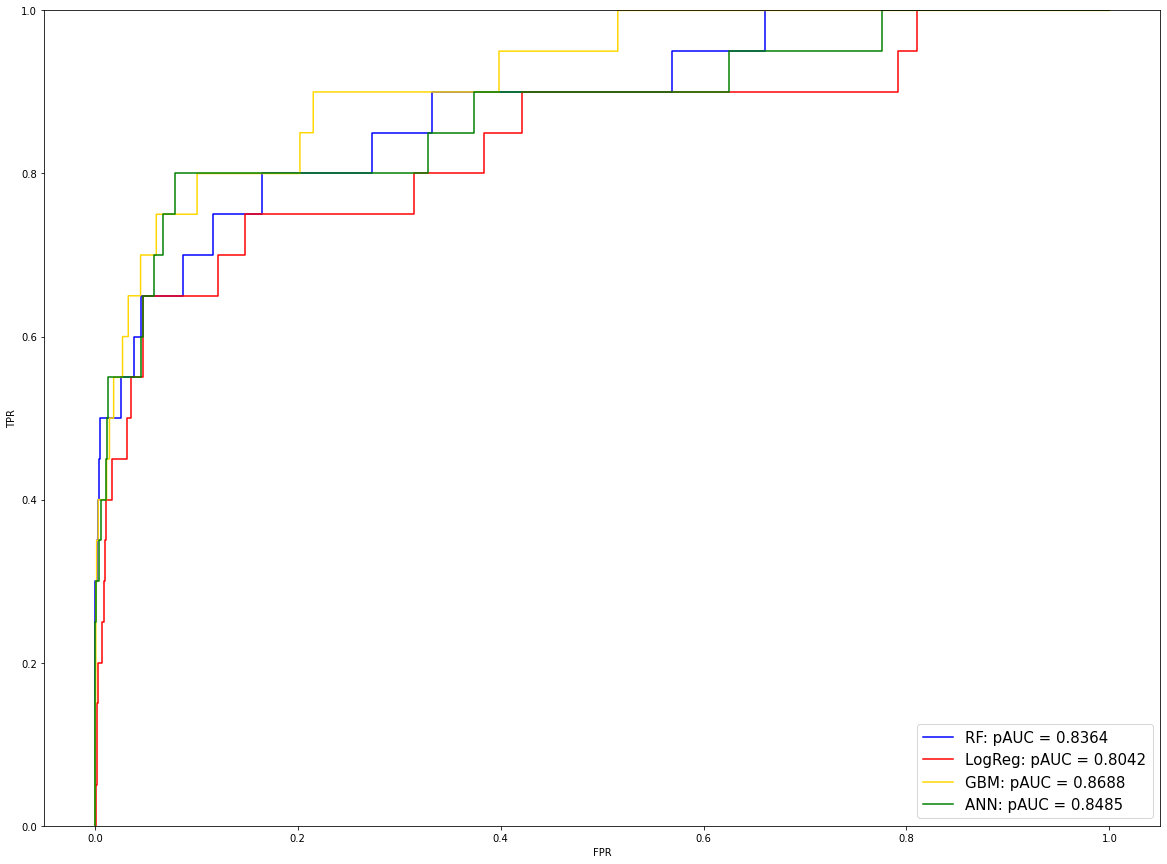

In [13]:
# ROC curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
f = plt.figure()
plt.rcParams["figure.figsize"] = (20,15)
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_ts, rf_probs[:,1])
fpr_logreg, tpr_logreg, threshold_logreg = metrics.roc_curve(y_ts, logreg_probs[:,1])
fpr_gbm, tpr_gbm, threshold_gbm = metrics.roc_curve(y_ts, gbm_probs[:,1])
fpr_ann, tpr_ann, threshold_ann = metrics.roc_curve(y_ts, ann_probs)
roc_auc_rf = metrics.roc_auc_score(y_ts, rf_probs[:,1], max_fpr = 0.3)
roc_auc_logreg = metrics.roc_auc_score(y_ts, logreg_probs[:,1], max_fpr = 0.3)
roc_auc_gbm = metrics.roc_auc_score(y_ts, gbm_probs[:,1], max_fpr = 0.3)
roc_auc_ann = metrics.roc_auc_score(y_ts, ann_probs, max_fpr = 0.3)
plt.plot(fpr_rf, tpr_rf, label = 'RF: pAUC = %0.4f' % roc_auc_rf, color = 'blue')
plt.plot(fpr_logreg, tpr_logreg, label = 'LogReg: pAUC = %0.4f' % roc_auc_logreg, color = 'red')
plt.plot(fpr_gbm, tpr_gbm, label = 'GBM: pAUC = %0.4f' % roc_auc_gbm, color = 'gold')
plt.plot(fpr_ann, tpr_ann, label = 'ANN: pAUC = %0.4f' % roc_auc_ann, color = 'green')
plt.ylim([0, 1])
plt.legend(loc = 'lower right', prop={'size': 15})
plt.xlabel('FPR')
plt.ylabel('TPR')

We may take a look at the pAUC/AUC scores our final models achieved on the test data. The partial AUC was calculated on the part of the ROC curve where the false positive rate was less than 30%. 

In [17]:
# pAUC, test data
print('Neural network pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, ann_probs, max_fpr = 0.3)))
print('Random forest pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, rf_probs[:,1], max_fpr = 0.3)))
print('Logistic regression pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, logreg_probs[:,1], max_fpr = 0.3)))
print('Gradient boosting machine pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, gbm_probs[:,1], max_fpr = 0.3)))


0.8484765747454217 0.8363518692675627 0.8042249390731022 0.8688352597356632
Neural network pAUC on test data: 0.84848.
Random forest pAUC on test data: 0.83635.
Logistic regression pAUC on test data: 0.80422.
Gradient boosting machine pAUC on test data: 0.86884.


In [21]:
# AUC, test data
print('Neural network AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, ann_probs)))
print('Random forest AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, rf_probs[:,1])))
print('Logistic regression AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, logreg_probs[:,1])))
print('Gradient boosting machine AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, gbm_probs[:,1])))

Neural network AUC on test data: 0.87762.
Random forest AUC on test data: 0.88348.
Logistic regression AUC on test data: 0.83908.
Gradient boosting machine AUC on test data: 0.91741.


As we can see, the neural network fell short of decision tree-based algortihms such as random forest or GBM. However, it had the best performance at the true positive rate equal to 80%, meaning it achieved the smallest false positive rate among the trained algorithms. 

The actual choice of the cut-off point depends on how risky we want to be when choosing which companies we want to invest in. A lower cut-off point ensures that most of the bankrupt companies will be labeled correctly, but a lot of financially healthy companies will be also incorreclty labeled as going banrkupt. On the other hand, higher cut-off point lowers the value of incorrectly labeled healthy companies, but raises the risk that some of the companies predicted as healthy were, in reality, going bankrupt. This choice wholly relies on the business decision. 

In this project, I chose the 80% true positive rate boundary and its corresponding cut-off value. We can look at the *confusion matrices*, which tell us how many observations from the positive/negative class were labeled correctly (elements on the diagonal) and how many of them were labeled incorrectly (elements not on the diagonal)

In [22]:
# Confusion matrices
from sklearn.metrics import confusion_matrix 
rf_p = threshold_rf[tpr_rf == 0.8][0]
logreg_p = threshold_logreg[tpr_logreg == 0.8][0]
gbm_p = threshold_gbm[tpr_gbm == 0.8][0]
ann_p = threshold_ann[tpr_ann == 0.8][0]

In [23]:
print('Random Forest:')
print(confusion_matrix(y_ts, (rf_probs[:,1] >= rf_p).astype('int')))

Random Forest:
[[3238  640]
 [   4   16]]


In [24]:
print('Logistic Regression:')
print(confusion_matrix(y_ts, (logreg_probs[:,1] >= logreg_p).astype('int')))

Logistic Regression:
[[2658 1220]
 [   4   16]]


In [25]:
print('GBM:')
print(confusion_matrix(y_ts, (gbm_probs[:,1] >= gbm_p).astype('int')))

GBM:
[[3487  391]
 [   4   16]]


In [26]:
print('ANN:')
print(confusion_matrix(y_ts, (ann_probs >= ann_p).astype('int')))

ANN:
[[3573  305]
 [   4   16]]


The price we pay so at least 80% of banrkupt companies are labeled correctly, is pretty high. The artificial neural network, which was the best performer at this TPR level, incorrectly predicted 305 companies as bankrupt, even though in reality, they were financially healthy. This might seem as a high number, but since predicting bankruptcy solely from financial ratios is a rather complex problem, this model did a pretty okay job. 

Next up, we may look at the cut-off values for each model that correspond to the TPR = 0.8 level.

In [48]:
# Cut-off points for TPR = 0.8
print('Optimal cut-off point, random forest: %.3f.' % round(threshold_rf[tpr_rf == 0.8][0], 3))
print('Optimal cut-off point, logistic regression: %.3f.' % round(threshold_logreg[tpr_logreg == 0.8][0], 3))
print('Optimal cut-off point, GBM: %.3f.' % round(threshold_gbm[tpr_gbm == 0.8][0], 3))
print('Optimal cut-off point, neural net: %.3f.' % round(threshold_ann[tpr_ann == 0.8][0], 3))

Optimal cut-off point, random forest: 0.524.
Optimal cut-off point, logistic regression: 0.009.
Optimal cut-off point, GBM: 0.397.
Optimal cut-off point, neural net: 0.464.


The following code illustrates the definition and training of benchmark ML models used in this project: A random forest, logistic regression and gradient boosting machine. In the name of consistency, I used the same preprocessing paradigm as I did for the neural network. In reality, decision tree-based models allow us to skip some of the steps (such as winsorization) as they might even hurt the performance of these models via loss of information. I wanted to maintain 'fairness' so I evaluated the performance of these models on the same data, hence I kept the same preprocessing steps. 

In [49]:
# Benchmark models
# Random Forest 
from sklearn.ensemble import RandomForestClassifier as RFC
rf = imbpipeline(steps = [['outs', WinsorTrans()],
                          ['scaler', MinMaxScaler()],
                          ['imputer', KNNImputer()], 
                          ['us', RandomUnderSampler()], 
                          ['os', RandomOverSampler()], 
                          ['clf', RFC()]])
params = {
    'outs__alpha' : [0.05],
    'imputer' : [KNNImputer(n_neighbors = 5)],
    'os' : [SMOTE(sampling_strategy = 0.75)],
    'us' : [RandomUnderSampler(sampling_strategy = 0.02)],
    'clf__n_estimators' : [600, 800, 1000],
    'clf__max_depth' : [2, 3, 4 , 5],
    'clf__max_features' : [8, 10, 12]
}


 > init() called.



In [50]:
from sklearn.model_selection import GridSearchCV
part_auc = make_scorer(roc_auc_score, max_fpr = 0.3)
forest = GridSearchCV(estimator = rf, 
                      verbose = 4,
                      scoring = part_auc,
                      param_grid = params,
                      cv = 4,
                      return_train_score = True)
forest.fit(X_tr, y_tr)


 > init() called.

Fitting 4 folds for each of 36 candidates, totalling 144 fits

 > init() called.



KeyboardInterrupt: 

In [95]:
import joblib 
joblib.dump(forest.best_estimator_, 'rf_konec.pkl')
pd.DataFrame(forest.cv_results_).to_csv('rf_konec.csv')

In [152]:
# Retrained RF 
rf_final = imbpipeline(steps = [['outs', WinsorTrans()],
                                ['scaler', MinMaxScaler()],
                                ['imputer', KNNImputer()], 
                                ['us', RandomUnderSampler()], 
                                ['os', RandomOverSampler()], 
                                ['clf', RFC(n_estimators = 600,
                                            max_depth = 3,
                                            max_features = 12)]])
rf_final.fit(X_tr, y_tr)


 > init() called.



Pipeline(steps=[('outs', WinsorTrans()), ('scaler', MinMaxScaler()),
                ('imputer', KNNImputer()), ('us', RandomUnderSampler()),
                ('os', RandomOverSampler()),
                ['clf',
                 RandomForestClassifier(max_depth=3, max_features=12,
                                        n_estimators=600)]])

In [153]:
joblib.dump(rf_final, 'rf_upraveny.pkl')

['rf_upraveny.pkl']

In [51]:
# Logistic regression
from sklearn.linear_model import LogisticRegression 
logreg = imbpipeline(steps = [['outs', WinsorTrans()],
                              ['scaler', MinMaxScaler()],
                              ['imputer', KNNImputer()], 
                              ['clf', LogisticRegression(solver = 'liblinear',
                                                         max_iter = 10000,
                                                         class_weight = 'balanced')]])
params = {
    'outs__alpha' : [0.05],
    'imputer' : [KNNImputer(n_neighbors = 5)],
    'clf__penalty' : ['l2', 'l1'],
    'clf__C': [0.01, 0.1, 1, 10, 100, 1000]
}
# C = 1/lambda, 1 - 1000, penalty l1/l2


 > init() called.



In [52]:
regres = GridSearchCV(estimator = logreg, 
                      verbose = 4,
                      scoring = part_auc,
                      param_grid = params,
                      cv = 4,
                      return_train_score = True)
regres.fit(X_tr, y_tr)


 > init() called.

Fitting 4 folds for each of 12 candidates, totalling 48 fits

 > init() called.



KeyboardInterrupt: 

In [156]:
pd.DataFrame(regres.cv_results_).to_csv('logreg_konec.csv')
joblib.dump(regres.best_estimator_, 'logreg_konec.pkl')

['logreg_konec.pkl']

In [53]:
# Gradient Boosting Machine 
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbm = imbpipeline(steps = [['outs', WinsorTrans()],
                             ['scaler', MinMaxScaler()],
                             ['imputer', KNNImputer()], 
                             ['us', RandomUnderSampler()], 
                             ['os', RandomOverSampler()], 
                             ['clf', GBC()]])
params = {
    'outs__alpha' : [0.05],
    'imputer' : [KNNImputer(n_neighbors = 5)],
    'os' : [SMOTE(sampling_strategy = 0.75)],
    'us' : [RandomUnderSampler(sampling_strategy = 0.02)],
    'clf__n_estimators' : [50, 100, 300, 500],
    'clf__max_depth' : [2, 3, 4],
    'clf__learning_rate' : [1, 0.1, 0.01, 0.001]
}


 > init() called.



In [54]:
gradboost = GridSearchCV(estimator = gbm, 
                         verbose = 4,
                         scoring = part_auc,
                         param_grid = params,
                         cv = 4,
                         return_train_score = True)
gradboost.fit(X_tr, y_tr)


 > init() called.

Fitting 4 folds for each of 48 candidates, totalling 192 fits

 > init() called.



KeyboardInterrupt: 

In [98]:
pd.DataFrame(gradboost.cv_results_).to_csv('gbm_konec.csv')
joblib.dump(gradboost.best_estimator_, 'gbm_konec.pkl')

['gbm_konec.pkl']

## Saliency
In the last part, I tried to define the *saliency* variable for each of the predictors according to an article written by duJardin [(link here)](https://www.sciencedirect.com/science/article/abs/pii/S0925231210001098). Since neural networks are a *black-box* algorithm, it is fairly difficult to determine which of the predictors were important in predicting the output variable. However, there have been some methods developed in the previous decade. They are usually described under the umbrella term *sensitivity analysis*. 

My main aim was to create a simple neural network with one hidden layer and simple architecture. I repeatedly trained this simple network and computed the saliency variable for each of the predictors, defined by duJardin. Then I looked at the predictors that repeatedly scored among the top in saliency, for various splits of the data. This is a very heuristic way of looking at the variable importance, but it might give us some insight into which of the features were more imporant that others.

I will not get into details of the definition of saliency and my results; they can be found in my Master's thesis which is on my github page (unfortunately, it is written in Slovak). 

In [59]:
# Saliency 
from sklearn.pipeline import Pipeline 
sampler = imbpipeline(steps = [['outs', WinsorTrans(alpha = 0.05)],
                           ['scaler', MinMaxScaler()],
                           ['imputer', KNNImputer(n_neighbors = 5)],
                           ['us', RandomUnderSampler(sampling_strategy = 0.02)],
                           ['os', SMOTE(sampling_strategy = 0.75)]])
transformer = Pipeline(steps = [['outs', WinsorTrans(alpha = 0.05)], 
                       ['scaler', MinMaxScaler()],
                       ['imputer', KNNImputer(n_neighbors = 5)]])


 > init() called.


 > init() called.



In [60]:
def create_net_sal():
    net = Sequential()
    net.add(Dense(20, input_dim = 60, activation = 'relu'))
    net.add(Dense(1, activation = 'sigmoid'))
    net.compile(loss = 'binary_crossentropy', 
                optimizer = 'adam', 
                metrics = AUC(thresholds = xseq))
    return net

In [64]:
from keras.callbacks import EarlyStopping
# Code test
X_tra, X_val, y_tra, y_val = tts(X_tr, y_tr, test_size = 0.25, stratify = y_tr)
X_tra_pp = sampler.fit_resample(X_tra, y_tra)
transformer.fit(X_tra)
X_val_pp = transformer.transform(X_val)
X_val = (X_val_pp, y_val)
callback = EarlyStopping(monitor = 'val_loss', patience = 10)
net = create_net_sal()
net.fit(X_tra_pp[0], X_tra_pp[1], validation_data = X_val, epochs = 300, verbose = 1, batch_size = 128,
                callbacks = [callback])


Epoch 1/300
42/42 [==============================] - ETA: 0s - loss: 0.6319 - auc_1: 0.5213

KeyboardInterrupt: 

In [65]:
def saliency(model):
  k = model.layers[0].get_weights()[0].shape[0]
  sal = [0] * k
  abs1 = abs(model.layers[0].get_weights()[0])
  abs2 = abs(model.layers[1].get_weights()[0])
  sec = abs2 / abs2.sum()
  fir = abs1.sum(axis = 0)
  for i in np.arange(k):
    sal[i] = float(np.dot(abs1[i,:] / fir, sec))
  return(pd.Series(sal))

In [66]:
S = pd.DataFrame()
for i in np.arange(20):
    X_tra, X_val, y_tra, y_val = tts(X_tr, y_tr, 
                                    test_size = 0.25, 
                                    stratify = y_tr)
    X_tra_pp = sampler.fit_resample(X_tra, y_tra)
    transformer.fit(X_tra)
    X_val_pp = transformer.transform(X_val)
    val = (X_val_pp, y_val)
    for j in np.arange(5):
        net = create_net_sal()
        net.fit(X_tra_pp[0], X_tra_pp[1], validation_data = val, 
                epochs = 300, verbose = 1, batch_size = 128,
                callbacks = [callback])
        ind = saliency(net).nlargest(20).index
        S = S.append(pd.Series(ind), ignore_index = True)

Epoch 1/300
41/42 [============================>.] - ETA: 0s - loss: 0.6268 - auc_2: 0.5201

KeyboardInterrupt: 

In [103]:
vals = S.stack().value_counts() 
at70 = set(vals[vals >= 70].index.values)
for i in at70:
    print('V%d' % i, end = ' ')

V3 V36 V7 V40 V42 V43 V45 V48 V17 V50 V55 V23 V56 

In [49]:
X_tr_pp = transformer.fit_transform(X_tr)
r = abs(pd.DataFrame(X_tr_pp).corr()) >= 0.8
G = []
for i in np.arange(60):
    k = set(r.iloc[:,i][r.iloc[:,i]].index.values)
    if len(k.intersection(at70)) == 0 and len(k) > 1:
        if not(k in G): G.append(k) 

NameError: name 'at70' is not defined

In [114]:
G_inst = []
for i in np.arange(len(grp)):
    temp = 0
    for j in np.arange(S.shape[0]):
        if len(set(S.iloc[j,:]).intersection(G[i])) != 0:
            temp = temp+1
    G_inst.append(temp)

In [115]:
dc = dict(zip([tuple(i) for i in G], G_inst))
dc

{(0, 2): 2,
 (10, 14): 2,
 (11, 12): 11,
 (10, 34, 14): 2,
 (18, 38): 57,
 (20, 22): 13,
 (26, 46): 26,
 (49, 29): 26,
 (33, 53): 15,
 (54, 34, 14): 6,
 (18, 58, 38): 61,
 (34, 54): 4,
 (57, 37): 79,
 (58, 38): 21}